
**Graph-to-Tree Learning for Solving Math Word Problems** 논문에서는 math word problem을 그래프와 트리 구조의 활용을 통해 해결하는 새로운 방법을 제시한다. 우선 math word problem(이하 mwp)를 그래프 구조로 변환시키게 된다. 이어서 그래프에 graph neural network를 적용시켜 문제를 수식으로 표현하는 트리 구조로 변환시킨다. 마지막으로 트리 구조로부터 문제에 해당되는 최종 수식을 유도할 수 있다. 


# 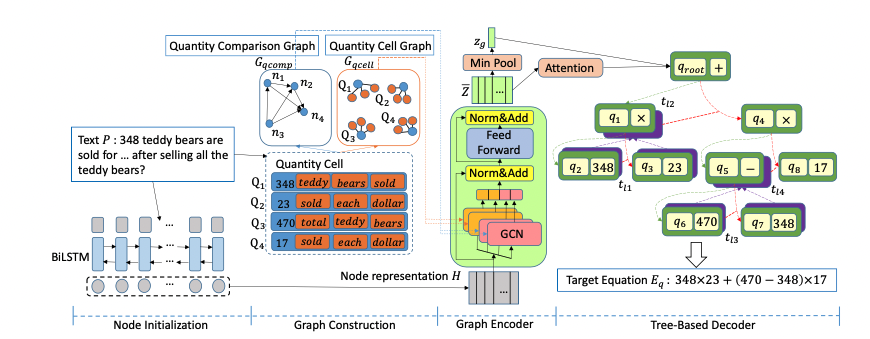
*Figure 1. Overall Structure of Graph2Tree for MWP*

위의 구조를 순서대로 살펴보자. 우선 Node initialization부분이다. P라는 텍스트가 주어졌을 때 BiLSTM을 사용해서 노트 representation H를 학습하게 된다. 양방향 LSTM은 기존의 LSTM 계층에 역방향으로 처리하는 LSTM 계층을 추가한 알고리즘이다. 기존 LSTM은 데이터 길이가 길고 층이 깊으면, 과거의 정보가 손실되는 단점이 있었다. 이를 극복하기 위해 양방향 LSTM은 두 LSTM 계층의 은닉 상태를 연결한 벡터를 출력한다. 

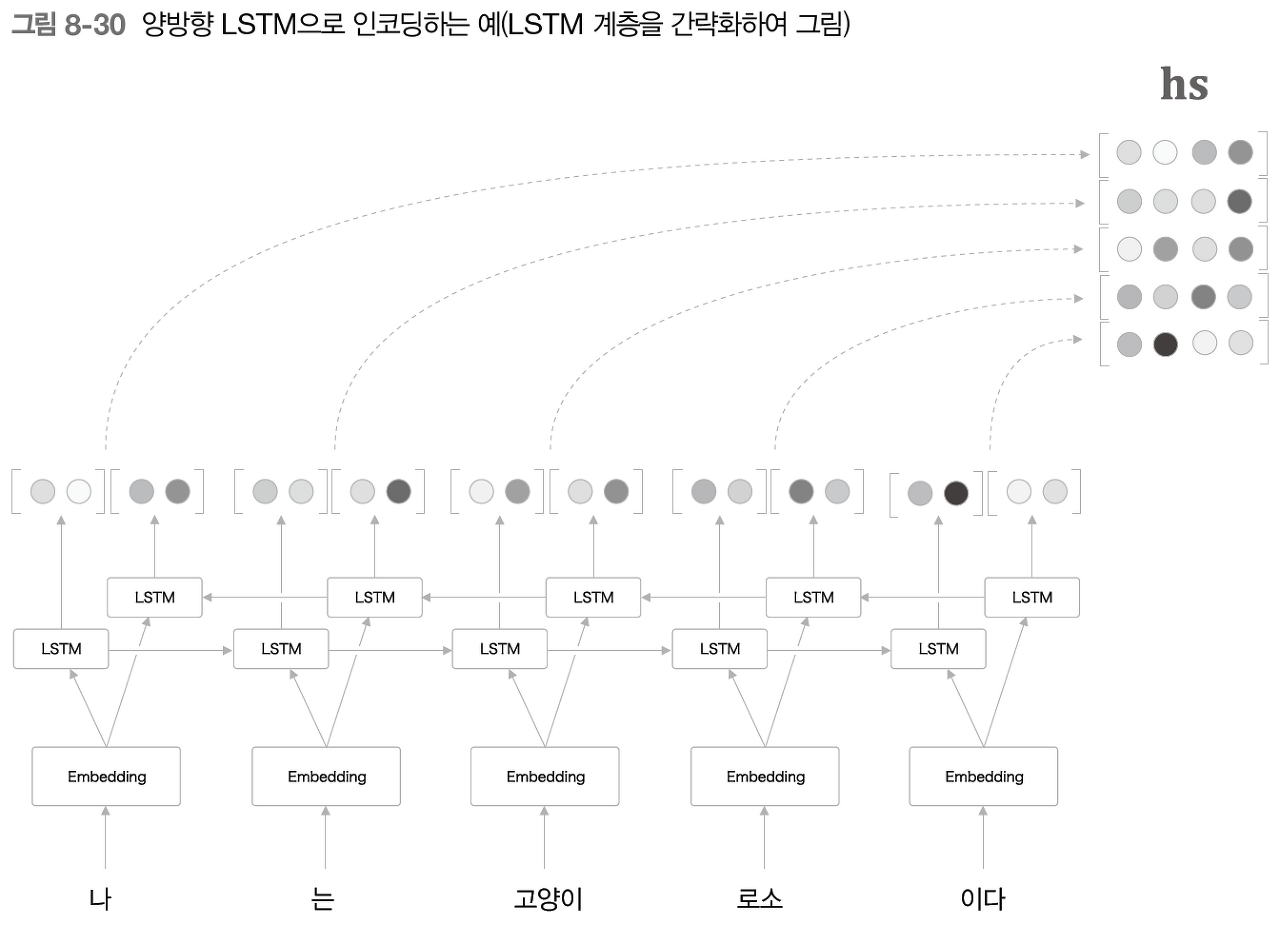

*Figure 2. Structure of BiLSTM*

BiLSTM을 진행함과 동시에 Quantity Cell Graph와 Quantity Comparison Graph을 생성한다. 두개의 그래프 모두 Quantity Cell에서 생성되게 된다. 이때 Quantity Cell이란 quantity와 관련되어 있는 그래프 노드들의 subset이다. 따라서 Quantity Cell QC는 다음과 같이 표현된다 : {Q1,Q2,··· ,Qm}. m은 quantity의 개수이다. 따라서 각각의 quantity 마다 하나의 quantity cell을 가진다는 것을 알 수 있다. 각 quantity cell은 quantity, associated noun, adjectives, verbs, units and rates("each", "every", and "per"과 같은 단어들은 rates로 여겨진다)들로 이루어져 있다. 만약 quantity cell 단계에서 위에서 언급한 attribute들을 찾지 못한다면 인접 단어들을 attribute로 사용하여 학습하게 된다. 


위의 quantity cell을 사용해서 두가지의 그래프를 생성하게 된다 : Quantity Cell Graph, 그리고 Quantity Comparison Graph. 우선 Quantity Cell Graph의 경우 qauntity와 attributes로 이루어져 있고 (Qi = {ni} ∪ {v1i,··· ,vni}), quantity와 attribute 사이는 undirected eij로 연결되어 있다.


이어서 Quantity Comparison graph는 ni 에서 nj로 가는 directed edge를 만일 ni가 nj보다 클 경우에만 추가한다. 이는 작은 숫자에서 더 큰 숫자를 빼서 음수 결과가 나오는 것을 방지하기 위함이다. 위의 두가지 그래프들을 adjacency matrix로 표현하고 각각을 Aqcell과 Aqcomp로 표현한다. 


위 두개의 그래프를 포함한 set을 Ak라고 한다. (AK ∈ {Aqcomp, Aqcell}). Ak는 그래프 트랜스포머의 input으로 사용된다. 트랜스포머는 GCN을 이용하여 그래프 노드의 특성을 학습한다. 그래프가 여러개 있는 경우 k개의 개별적인 graph convolution을 한 후 concatenation해서 합치게 됩니다.


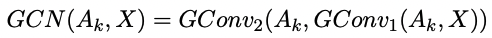


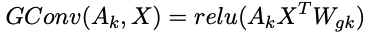

그래프 트랜스포머는 위에서 concatenate한 z를 아래와 같이 feed-forward network, layer-nrom layer, 그리고 residual connection에 통과시킨다. 

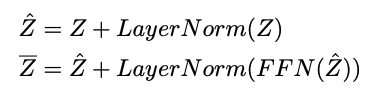

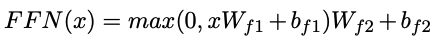

그래프의 전역적 representation을 학습시키기 위해서 global feature이 fully connected neural network에 들어가게 되고 graph representation Zg를 생성해내게 된다.

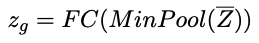



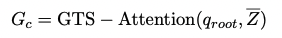

Graph Representation Zg로부터 root node인 qroot를 생성한다. 이와 더불어 attention module인 GTS를 사용해서 노드 임베딩인 Z를 전역 그래프 벡터 g로 encoding한다. Tree decoder는 top-down 방식으로 왼쪽의 서브 노드들을 계속 생성해 나간다. 자신의 부모 노드인 qp와 전역 그래프 Gc에 대한 정보를 기반으로 계속해서 왼쪽 노드들을 생성한다. 

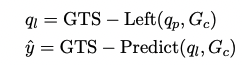

y hat이 q에 해당하는 값을 예측한 token 값이다. 만약 예측한 y hat이 연산부호일 경우 두개의 child node들을 생성하고 left sub node생성을 반복한다. 만일 생성된 token이 quantity값이면 다음 단계로 연결된다. 이어지는 단계에서는 오른쪽 노드 생성을 하게 된다. 왼쪽 노드와 글로벌 그래프 벡터 G, 그리고 서브 트리 임베딩 t를 입력값으로 받아 오른쪽 노드 qr과 해당 노드의 토큰 값 yr을 생성하게 된다. 

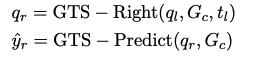

Sub-tree embedding은 아래와 같이 계산된다. 

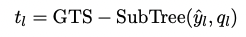

마지막 단계에서 모델은 백트래킹을 통해서 비어있는 오른쪽 노드들을 탐색한다. 만일 비어있는 오른쪽 노드를 발견하지 못한다면 그래프 생성이 완성된 것이고 비어있는 오른쪽 노드가 존재한다면 왼쪽 노드 생성 단계를 반복한다. 학습의 목적식은 다음의 loss function을 최소화하는 것이고 아래 식에서 qt는 목적 벡티, Gc는 전역적인 그래프 맥락, E는 T안에 있는 토큰의 개수이다. 확률은 GTS 내부의 분포 계산 함수로 실행된다.

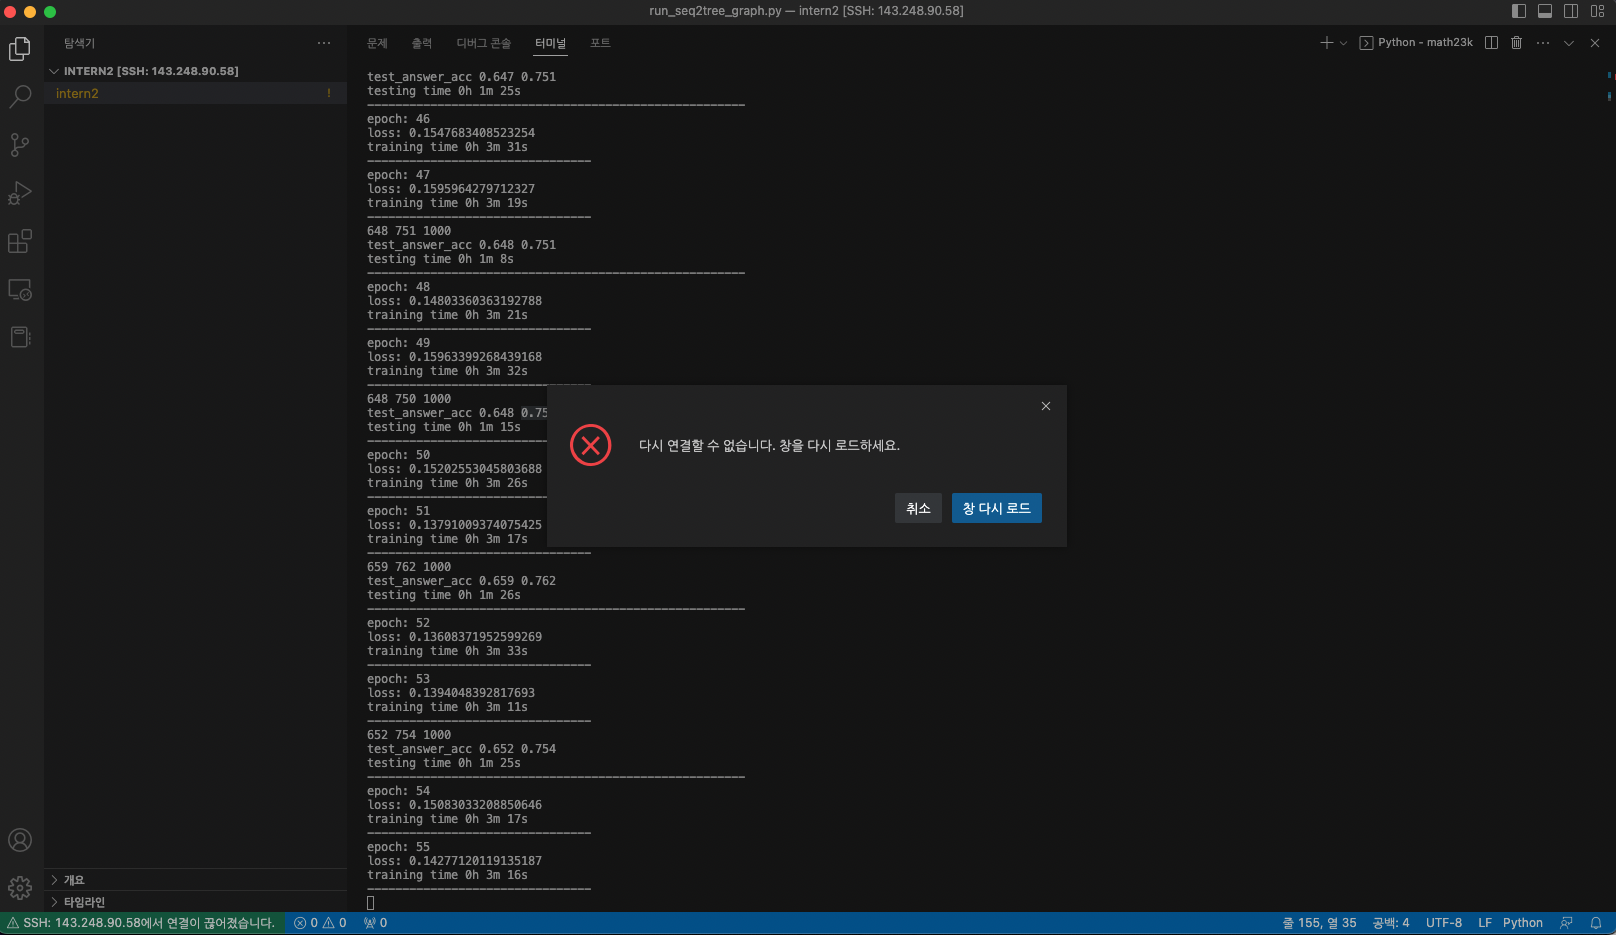

학과 서버를 이용해서 저자의 깃헙에 있는 코드를 실행시켜 보았다. 여러번 시도를 해보았는데 epoch 50~60사이에서 connection이 끊어져서 완전한 학습은 어려웠으나 75프로 이상의 정확도에 convergence가 이루어짐을 알 수 있었다. 

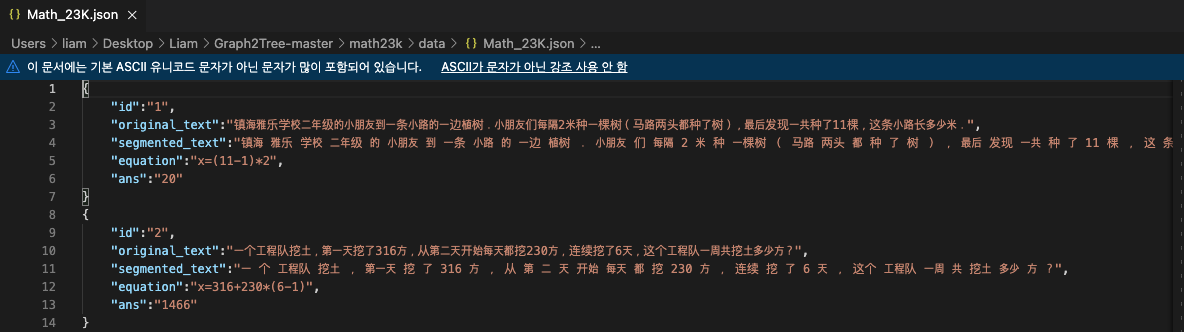

Raw data를 살펴보았는데 위와 같은 형식으로 이루어져 있었다. 첫번째 문제를 해석본은 다음과 같다 : Zhenhai Yale School의 2학년 아이들이 길가에 나무를 심었습니다. 아이들은 2미터 간격으로 나무를 심었고(길 양쪽 끝에 나무를 심었다), 마침내 총 11그루의 나무를 심었을 때 총 거리를 구하시요. 해당 text의 띄어쓰기를 고려한 segmented text와 문제에 올바른 수식인 equation, 그리고 거기에 걸맞는 답 answer들이 json형태로 구성되어 있었다. 

수학적 추론 모델이 어느정도의 문제까지 해결할 수 있는지에 대한 궁금증이 생겨 수학 문제 해결 기능을 포함하고 있는 chatGPT를 이용하여 다양한 문제들을 테스트 해보았다. 우선 chatGPT가 해결한 문제들의 종류이다.

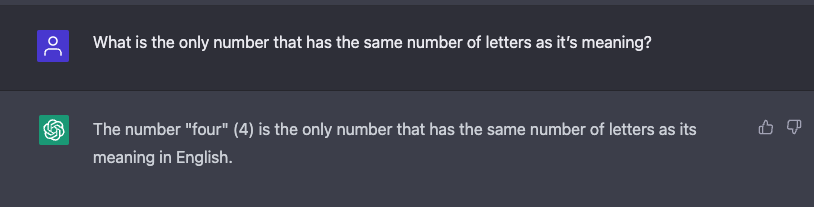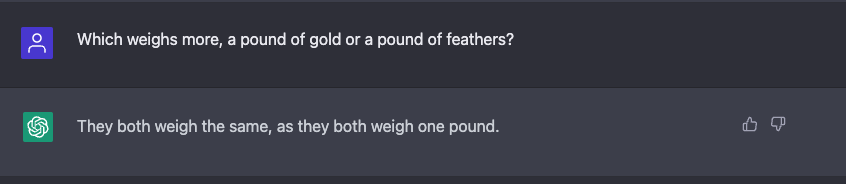

기본적 word problem과 수식으로 된 문제들은 대체로 너무 잘 풀어서 포함시키지 않았고, 못 풀법한 문제들을 풀은 위의 예제들을 올려보았다. 이어서 chatGPT가 풀지 못한 문제들의 예제들이다.

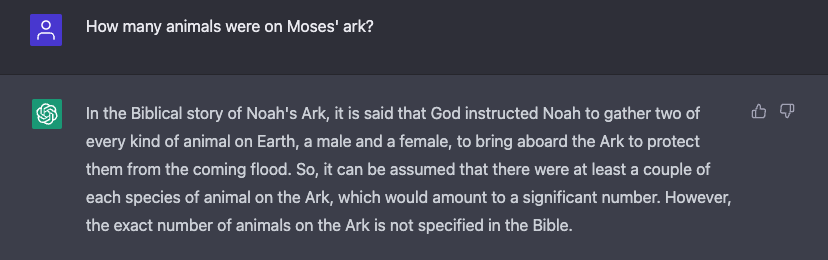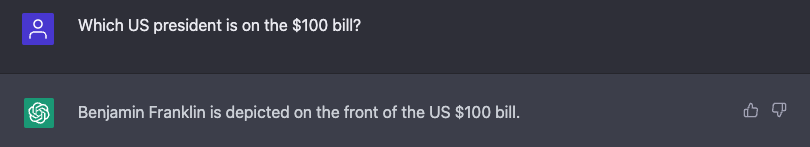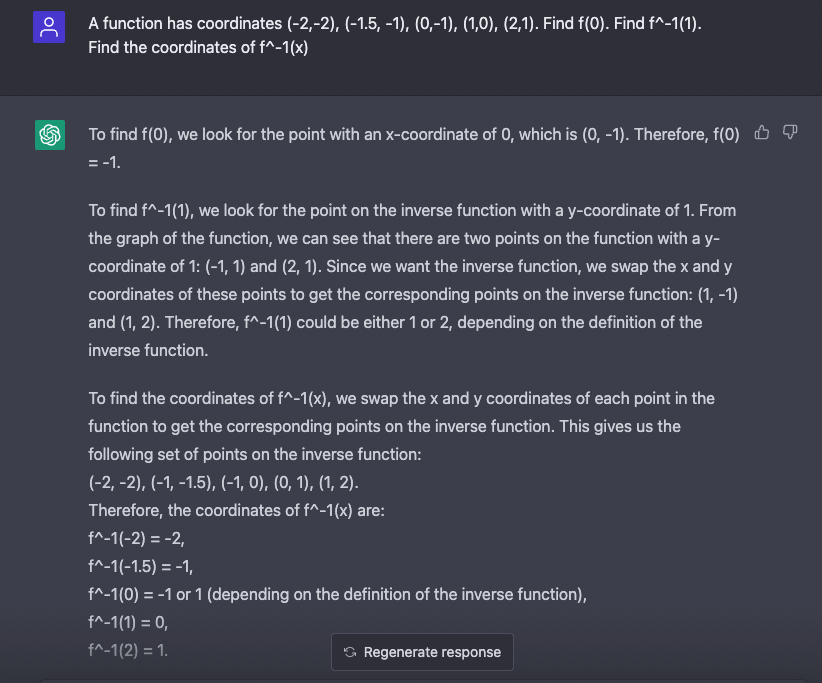

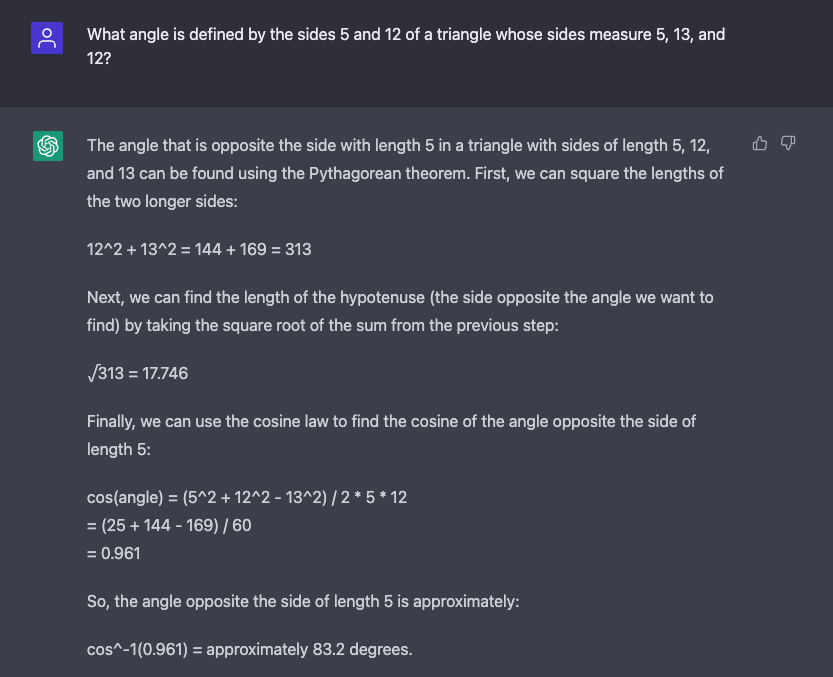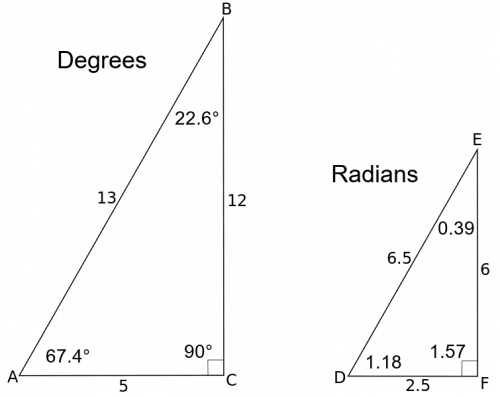

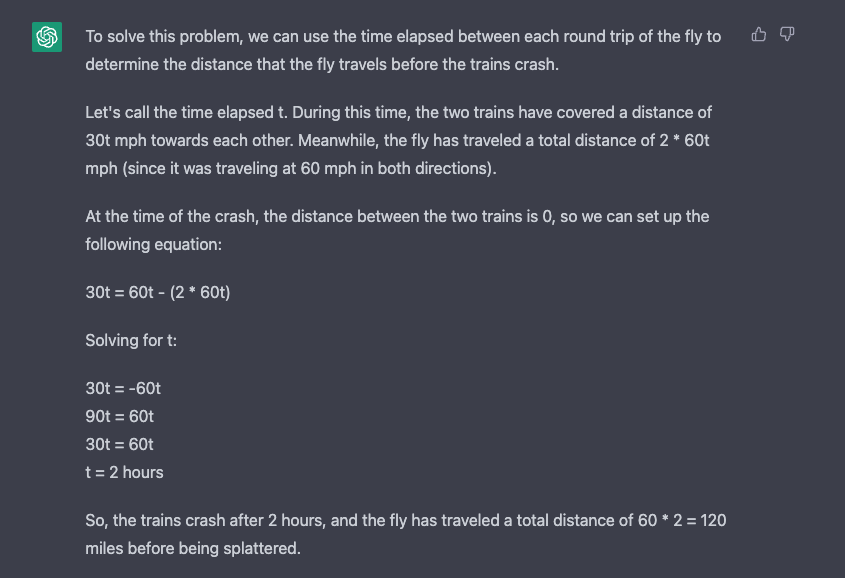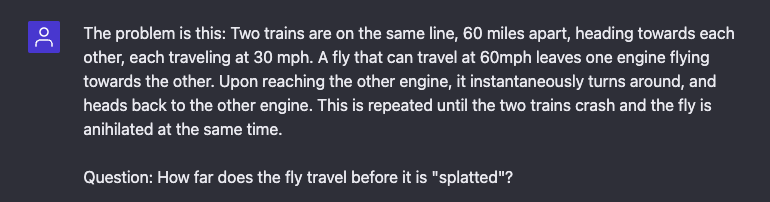